In [1]:
%autosave 500

Autosaving every 500 seconds


In [2]:
# Python libraries
import re, datetime, pprint, math, os, glob, time, numpy as np, matplotlib.pyplot as plt
#%matplotlib inline
import sys, uuid, shutil, datetime
from copy import deepcopy

# pymatgen libraries
from pymatgen import Lattice, Structure, Specie
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.periodic_table import Element

from pymatgen.io.vasp import Poscar

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from matplotlib import cm
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator

pwd = os.getcwd()
date = datetime.datetime.now()
print('Last ran on', pwd, 'from ', date)
## add in file change log to auto update by appending to a .* file 

Last ran on /home/tboland1/Dropbox/Crozier Group User- Tara Boland/pymatgen from  2018-11-01 15:17:15.067842


### Function Definition

In [23]:
[[x,list(migration_data[x].keys())] for x in migration_data.keys()]

[['oxy_path', ['coords', 'nn_periodic_sites', 'combined_struct']],
 ['hop_path', ['coords', 'nn_periodic_sites', 'combined_struct']],
 ['tot_migpath_struct', ['struct', 'nn_data']]]

The dictionary keys for the nearest neighbor lists which was populated using get_nn_path_from_sites

In [17]:
def get_nn_path_from_sites(oxy_path,hop_path,r):
    # the migration path data
    nn_lists={"oxy_path":{'coords':oxy_path},"hop_path":{'coords':hop_path}}
    nn_tot_path_sites = []

    # search each list along path list for NN Ce atoms
    for path in list(nn_lists.keys()):
        # site arrays
        nn_path_sites=[]
        # create 2nd level dictionaries
        nn_lists[path]["nn_periodic_sites"]={}
        nn_lists[path]["combined_struct"]={}

        for path_atoms in nn_lists[path]['coords']:
            #create new site dict structure
            site_num = "site_"+str(nn_lists[path]["coords"].index(path_atoms))
            nn_lists[path]["nn_periodic_sites"][site_num]={}
            # obtain the nn sites
            nn_path_data = structure_neb.get_sites_in_sphere(pt=path_atoms,
                                                               r=r,
                                                               include_index=True,
                                                               include_image=True)

            # create individual structures @ each site
            nn_struct = Structure.from_sites([site[0] for site in nn_path_data])

            # append data to dictionary
            nn_lists[path]["nn_periodic_sites"][site_num]["coords"]=path_atoms
            nn_lists[path]["nn_periodic_sites"][site_num]["ce_ce_dis"]=ce_ce_dist(['Ce','Ce3+'],nn_struct)[0]
            nn_lists[path]["nn_periodic_sites"][site_num]["nn_data"]=nn_path_data  # output from get_sites_in_sphere
            nn_lists[path]["nn_periodic_sites"][site_num]["struct"]=nn_struct      # structure for each nn site
            
            
            # create NN oxygen path structure (@ each coord for every mig path)
            nn_path_sites+=[site[0] for site in nn_path_data]

        # add structure path to 1st level struct array holder
        nn_tot_path_sites+=[site for site in nn_path_sites]

        nn_lists[path]["combined_struct"]['struct'] = Structure.from_sites([site for site in nn_path_sites]) # populate struct
        nn_lists[path]['combined_struct']['nn_data'] = nn_path_sites  # populate nn_data
        print(path)
        gvl(nn_lists[path]["combined_struct"]['struct'])

    # total structure
    nn_lists['tot_migpath_struct']={}
    nn_lists['tot_migpath_struct']['struct'] = Structure.from_sites([site for site in nn_tot_path_sites]) # populate struct
    nn_lists['tot_migpath_struct']['nn_data'] = nn_tot_path_sites  # populate nn_data
    # visualize GB migration pathways
    print('total path')
    gvl(nn_lists['tot_migpath_struct']['struct'])
    return nn_lists

### Nearest neighbor Ce_Ce_distance calculator 

still need to figure out how to put in exceptions for when a site does not have 2 nn ce atoms to determine the ce-ce distance from. 

* have to catch when it is less than 
* have to catch when it is greater than

Error handling ideas
* exception should through an increase or decrease radius appended to the norm for each site. 

In [18]:
def ce_ce_dist(target_specie,structure):
    '''
    Input Args:
    target_specie = ["Ce","Ca","Ti"]
    structure = NN structure aorund the site of interest
    
    Add code to take in the periodic site and if the search fails run with a smaller of larger radius 
    
    Output:
    site_norm = value
        distance between the two points or information on why 
        it failed to find the distance along with point which failed. 
    '''
    target_count = 0
    targets_found = []
    for atom in structure:
        if str(atom.specie) in target_specie:   
            target_count+=1
            targets_found.append(atom)
    target_len = len(targets_found)

    if target_count == 2:
        norm = [x**2 for x in (targets_found[1].coords - targets_found[0].coords)]
        site_norm = math.sqrt(norm[0]+norm[1]+norm[2])
    elif target_count > 2 :
        site_norm = ['decrease r',atom]
    elif target_count < 2 :
        site_norm = ['increase r',atom]

    return site_norm, target_len

Testing done for the ce_ce_dist function above

# Get the oxygen sites along the GB migration pathway.

Ca atoms in this GB corresponds to an oxygen atom along the migration pathway 
Ti atoms correspond to the Ce 3+ atoms.

In [4]:
# read in the file
pwd = os.getcwd()
to_path = pwd+"/read/"+"poscar_gb_neb_path"

# look at the structure
poscar = Poscar.from_file(to_path)
gvl(poscar)
structure_neb = poscar.structure
structure_neb["Ti"]="Ce3+"

oxy_path=[]
# searches struct for the target migration pathway atoms,
# counts the total # of atoms along the path
charge_counter=0
for atom in structure_neb:
    # get the element symbol from the structure
    atom_tag = str(atom.specie)
    # search the array for the target atoms to search around
    if atom_tag == "Ca":
        oxy_path.append(list(atom.coords))
        flag_atom_tag = 1
        #set site counter for specie you wish to count
        charge_counter+=1
print("The number of migration sites along the GB is",charge_counter,'\n')

# searches for each target atom which is part of the
# migration path, gets the number of atoms in the sphere 
# for each site and returns 
nn={}
oxypath_counter=0
flag_atom_tag = 0
site_keys = ['site'+str(i) for i in range(charge_counter)]
for atom in structure_neb:
    # get the element symbol from the structure
    atom_tag = str(atom.specie)
    # search the array for the target atoms to search around
    if atom_tag == "Ca":   
        flag_atom_tag = 1
        #set site counter for specie you wish to count
        charge_counter=0
        # get the NN list around the site of interest
        nn_lists = structure_neb.get_neighbors(site=atom,r=10,
                                              include_index=True,
                                             include_image=True)
        # look around the NN list of the specie of interest for 
        # the site of interest
        for dopant_atom in range(len(nn_lists)):
            specie_item = nn_lists[dopant_atom][0].species_string
            # count number of species of 
            # interest within radius r @ site of interest
            if specie_item == 'Ce3+':
                charge_counter += 1
    # now append the collected data to the nn list if the             
    if flag_atom_tag == 1:
        nn[site_keys[oxypath_counter]]={}
        nn[site_keys[oxypath_counter]]['location']=list(atom.coords)
        nn[site_keys[oxypath_counter]]['defect_count']=charge_counter
        oxypath_counter+=1
        flag_atom_tag = 0
print("The data structure, nn, looks like", nn,'\n')
#nn['site0']['location'][1]
print("\nThe atom types are", structure_neb.composition)

The number of migration sites along the GB is 11
The data structure, nn, looks like {'site0': {'location': [3.9178902, 43.3318405, 3.4427808], 'defect_count': 17}, 'site1': {'location': [2.7672014, 46.8847352, 3.5725007], 'defect_count': 15}, 'site2': {'location': [1.3630668, 44.4927025, 3.3554447], 'defect_count': 18}, 'site3': {'location': [3.9013558, 49.4347763, 3.4136303], 'defect_count': 8}, 'site4': {'location': [5.1965747, 51.8946382, 3.3842504], 'defect_count': 2}, 'site5': {'location': [5.6301413, 32.7545204, 5.9376136], 'defect_count': 6}, 'site6': {'location': [4.4259978, 35.1943512, 5.93504], 'defect_count': 8}, 'site7': {'location': [3.1263146, 37.5995369, 5.8430986], 'defect_count': 14}, 'site8': {'location': [1.8964766, 40.2242737, 5.8130145], 'defect_count': 18}, 'site9': {'location': [4.6166492, 41.5817604, 5.4711199], 'defect_count': 18}, 'site10': {'location': [3.4036918, 43.9119264, 5.919323], 'defect_count': 18}}

The atom types are Ce270 O564 Ce3+24 Ca11


In [5]:
lat = Lattice.cubic(5.413)  # define the lattice
coord = [[0,0,0],[0.25,0.25,0.25]]  # symmetry enfored basis coords
ceria_struc = Structure.from_spacegroup(sg="Fm-3m",lattice=lat,
                                      species=["Ce","O"],
                      coords=coord)   # create the structure
structure = ceria_struc.copy()
lat = Lattice.cubic(5.413)  # define the lattice
coord = [[0,0,0],[0.25,0.25,0.25]]  # symmetry enfored basis coords
ceria_struc = Structure.from_spacegroup(sg="Fm-3m",lattice=lat,
                                      species=["Ce","O"],
                      coords=coord)   # create the structure
structure = ceria_struc.copy()

ce_ce_bulk = structure.get_distance(1,2)

### Get migration pathway charged sites from the dictionary to plot

In [6]:
site, loca = zip(*(sorted(nn.items())))
x,y,z,defect = [loc['location'][0] for loc in loca],\
[loc['location'][1] for loc in loca],\
[loc['location'][2] for loc in loca],\
[loc['defect_count'] for loc in loca]
print(site,'\n',x,len(x),'\n', y,len(x),'\n',z,len(x),'\n',defect)

('site0', 'site1', 'site10', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9') 
 [3.9178902, 2.7672014, 3.4036918, 1.3630668, 3.9013558, 5.1965747, 5.6301413, 4.4259978, 3.1263146, 1.8964766, 4.6166492] 11 
 [43.3318405, 46.8847352, 43.9119264, 44.4927025, 49.4347763, 51.8946382, 32.7545204, 35.1943512, 37.5995369, 40.2242737, 41.5817604] 11 
 [3.4427808, 3.5725007, 5.919323, 3.3554447, 3.4136303, 3.3842504, 5.9376136, 5.93504, 5.8430986, 5.8130145, 5.4711199] 11 
 [17, 15, 18, 18, 8, 2, 6, 8, 14, 18, 18]


<IPython.core.display.Javascript object>


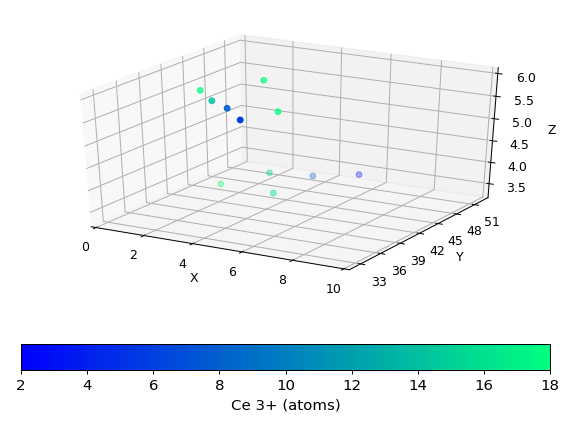

In [7]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ca = ax.scatter(x, y, z, c=defect, cmap=cm.winter)
xmin=0
xmax=10
# Label the axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# axis, plot label 
ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)

# control the look and fee
ax.tick_params(axis='y', labelsize=10,length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# control plot look with rc
plt.rc('font', size=12)
#doesnt work ca.rc('font', size=14)

# Create the 4th dimension scale bar color map, Add colorbar, make sure to specify tick locations to match desired ticklabels
m = cm.ScalarMappable(cmap=cm.winter)
m.set_array(defect)
cbar = plt.colorbar(m,orientation='horizontal')
cbar.set_label("Ce 3+ (atoms)")
## vertical color bar
#cbar = fig.colorbar(m, ticks=[-1, 0, 1])
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

plt.tight_layout()
plt.show()

## The total # of Ce$^{3+}$ within 10 $\unicode{x212B}$ of each oxygen atom at the transition state along the GB migration pathway

Each point in the graph above corresponds to the number of Ce$^{3+}$ atoms within 10 $\unicode{x212B}$. 
A list of all the transition state coordinates for each of migrating oxygen atom is represented in the graph below. This is the trasition state between site x and site x+1. 

In [8]:
# the lcoations are from the lammps gb directory 1.4-*sigma/ 4/2-gb/ dir $.1-ts
hop_path=[[5.79361,53.0793,3.37952],[4.54078,50.6449,3.3975],
          [3.32809,48.1866,3.47486],[2.08854,45.6588,3.51838],
          [2.7319,43.7749,3.43027],[3.67546,43.5438,4.70323],
          [4.00718,42.5853,5.82163],[3.34603,40.8511,5.65499],
          [2.58527,39.0121,5.8991],[3.76648,36.4326,5.87528],
          [5.02526,33.9833,5.94037]]
""" error in the coords: hop_path2=[[5.79361,53.0793,3.37952],[4.54078,50.6449,3.3975],
          [3.32809,48.1866,3.47486],[2.08854,45.6588,3.51838],
          [2.7319,43.7749,3.43027],[3.67546,43.5438,4.70323],
          [4.00718,42.5853,5.82163],[1.98594,40.1723,5.82594]***,
          [2.58527,39.0121,5.8991],[3.76648,36.4326,5.87528],
          [5.02526,33.9833,5.94037]]
"""
x_hop, y_hop, z_hop = [hop[0] for hop in hop_path],[hop[1] for hop in hop_path],[hop[2] for hop in hop_path]

Searches around each transition state site for Ce$^{3+}$ along the GB migration pathway.

In [9]:
nn_sites = [structure_neb.get_sites_in_sphere(pt=loc,r=10,
                                              include_index=True,include_image=True) for loc in hop_path]  
nsites_rc=[]
for site in nn_sites:
    nn_temp = 0
    for element in site:
        #print(element[0].species_string)
        if element[0].species_string == "Ce3+":
            nn_temp+=1
    nsites_rc.append(nn_temp)
#nsites_rc

### Plot the oxygen atom positions with the transition state positions and color bar corresponding to the number of Ce$^{3+}$ within the cut off radius

<IPython.core.display.Javascript object>


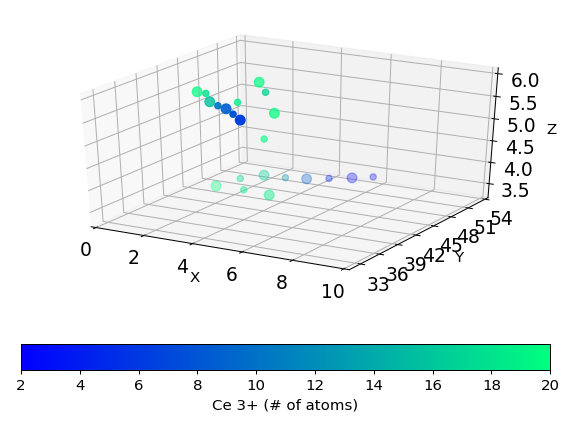

In [10]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ca1 = ax.scatter(x, y, z, c=defect, cmap=cm.winter, s=60)
ca2 = ax.scatter(x_hop, y_hop, z_hop, c=nsites_rc, cmap=cm.winter, s=25)

xmin=0
xmax=10

#!#!#!#!#!#        COLOR MAP
# scale bar, color map
m = cm.ScalarMappable(cmap=cm.winter)
m.set_array(nsites_rc+defect)
cbar = plt.colorbar(m,orientation='horizontal')
cbar.set_label("Ce 3+ (# of atoms)")
## vertical color bar
#cbar = fig.colorbar(m, ticks=[-1, 0, 1])
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar


#!#!#!#!#!# Label the axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#!#!#!#!#!# axis, plot label 
ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)
#!#!#!#!#!# control the look and feel of the 2d plot
ax.tick_params(axis='x', labelsize=15,length=0)
ax.tick_params(axis='y', labelsize=15,length=0)
ax.tick_params(axis='z', labelsize=15,length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#!#!#!#!#!# control plot look with rc
#plt.rc('font', size=12)
#plt.rcParams['lines.markersize']**4

plt.tight_layout()
plt.show()

## Get the Ce-Ce nearest neighbors for each vacancy
For comparison: Search using both the oxy_path and the the hop_path sites. They should produce the same results.

Creates structures populated with the NN atoms for each oxygen site and \@ each transisition state.
Structures created are:

    Full NN migration pathway structure for radius = 2.4, 2.6           (nn_path_structR$_tot)
    Individual NN Structure @ each point along the migration pathway.     (nn_path_structR$)
    Full NN initial state migration pathway structure.                    ()
    Full NN transition state migration pathway structure.                 ()
Directly below is the code to load ASE visulatization tools to create in line 3D vis structures to manipulate.

In [11]:
from ase.visualize import view
import nglview
from pymatgen.io.ase import AseAtomsAdaptor
to_ase = AseAtomsAdaptor()

Existing keys in the dictionary

1st level keys
"migration_path_data"
    This level is the data collected for each migration pathway.
    Examples: 
    "oxy_path":{path_data} where oxy_path is the initial state coords for oxygen atoms along a user-specificed path
    "hop_path":{path_data} where hop_path is the transition state coords for oxygen atoms along a user-specificed 
    path

2nd level keys    
"coords"  
    An array (1x3 array) which has the x,y,z coordinates of the oxygen atom
    Examples:
    nn_lists["oxy_path"]["coords"]=[[0,2,3],[4,2,1]] A list of the migration pathway coordinates representing the 
    location of the oxygen atoms when in the intitial state

"nn_periodic_sites"
    An dictionary containing of nearest neighbor sites within a specified radius. One element per every site in the 
    "coords" array. Obtained using "get_sites_in_sphere" 
    
"combined_struct"
    A dictionary containing complete migration pathway structure ("struct") and the periodic sites (periodic_sites)
    corresponding to 1st level key.
    Keys:
    "struct"
    "periodic_sites"

New dictionary keys for the migration pathway
"nn_sites"
""

** Be sure to run the get_nn_path_from_sites and the ce_ce_dist funcitons code below.

In [19]:
migration_data = get_nn_path_from_sites(oxy_path,hop_path,r=2.6)

oxy_path


hop_path


total path


In [20]:
migration_data_r24 = get_nn_path_from_sites(oxy_path,hop_path,r=2.4)

oxy_path


hop_path


total path


In [21]:
sites_key = list(migration_data['oxy_path']['nn_periodic_sites'].keys())
dist = [[x,migration_data['hop_path']['nn_periodic_sites'][x]['ce_ce_dis'],\
         migration_data['hop_path']['nn_periodic_sites'][x]['coords']] \
        for x in migration_data['hop_path']['nn_periodic_sites'].keys()]

<IPython.core.display.Javascript object>


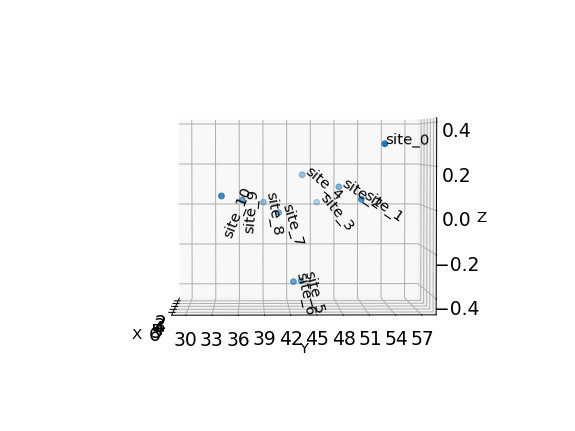

AttributeError: 'Figure' object has no attribute 'Figure'

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cecebulk = 3.827569006562782
labels,cecedist,x,y,z = [row[0] for row in dist],[row[1]-ce_ce_bulk for row in dist],\
[row[2][0] for row in dist],[row[2][1] for row in dist],[row[2][2] for row in dist]  

ca1 = ax.scatter(x, y, cecedist)

# site text labels
''''''
for i in range(len(labels)):
    ax.text(x[i],y[i],cecedist[i],labels[i],'x')


#!#!#!#!#!# Label the axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#!#!#!#!#!# axis, plot label 
ax.set_xlim(min(x)-1,max(x)+1)
ax.set_ylim(min(y)-5,max(y)+5)
ax.set_zlim(min(cecedist)-0.1,max(cecedist)+0.1)
#!#!#!#!#!# control the look and feel of the 2d plot
ax.tick_params(axis='x', labelsize=15,length=0)
ax.tick_params(axis='y', labelsize=15,length=0)
ax.tick_params(axis='z', labelsize=15,length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#!#!#!#!#!# control plot look with rc
#plt.rc('font', size=12)
#plt.rcParams['lines.markersize']**4

plt.tight_layout()
plt.show()

In [33]:
migration_data['tot_migpath_struct']['struct'].to(fmt="POSCAR",filename='POSCAR_migrationpath')

# ASE Visualization Code

In [28]:
structure_totmp = migration_data['tot_migpath_struct']['struct']
structure_oxymp = migration_data['oxy_path']['combined_struct']['struct']

In [34]:
struct_totmp_ase = to_ase.get_atoms(structure_totmp)
struct_oxymp_ase = to_ase.get_atoms(structure_oxymp)

In [50]:
view(struct_totmp_ase,viewer='vtk')
viewer

RuntimeError: Unknown viewer: vtk

In [42]:
from ase.io import write
write('GB-migration-path.png',struct_totmp_ase,show_unit_cell=2)

## Fix the search criteria for the NN list around each vacancy's transition state.

In [ ]:
r=2.4

# the migration path data
nn_lists={"oxy_path":{'coords':oxy_path},"hop_path":{'coords':hop_path}}
nn_tot_path_sites = []

# search each list along path list for NN Ce atoms
for path in list(nn_lists.keys()):
    # site arrays
    nn_path_sites=[]
    # create 2nd level dictionaries
    nn_lists[path]["nn_periodic_sites"]={}
    nn_lists[path]["combined_struct"]={}

    for path_atoms in nn_lists[path]['coords']:
        #create new site dict structure
        site_num = "site_"+str(nn_lists[path]["coords"].index(path_atoms))
        nn_lists[path]["nn_periodic_sites"][site_num]={}
        # obtain the nn sites
        nn_path_data = structure_neb.get_sites_in_sphere(pt=path_atoms,
                                                           r=r,
                                                           include_index=True,
                                                           include_image=True)

        # create individual structures @ each site
        nn_struct = Structure.from_sites([site[0] for site in nn_path_data])

        # append data to dictionary
        counter = 0
        '''
        while isinstance(ce_ce_dist(['Ce'],nn_struct)[0],float) == False:
            r+=1
            counter+=1
            nn_path_data = structure_neb.get_sites_in_sphere(pt=path_atoms,
                                                           r=r+0.01,
                                                           include_index=True,
                                                           include_image=True)
            print('loop',r)
            nn_struct = Structure.from_sites([site[0] for site in nn_path_data])
            if counter == 3:
                break;
        '''
        nn_lists[path]["nn_periodic_sites"][site_num]["ce_ce_dis"]=ce_ce_dist(['Ce'],nn_struct)[0]
        nn_lists[path]["nn_periodic_sites"][site_num]["nn_data"]=nn_path_data  # output from get_sites_in_sphere
        nn_lists[path]["nn_periodic_sites"][site_num]["struct"]=nn_struct      # structure for each nn site
        print(isinstance(ce_ce_dist(['Ce'],nn_struct)[0],float))

        # create NN oxygen path structure (@ each coord for every mig path)
        nn_path_sites+=[site[0] for site in nn_path_data]

    # add structure path to 1st level struct array holder
    nn_tot_path_sites+=[site for site in nn_path_sites]

    nn_lists[path]["combined_struct"]['struct'] = Structure.from_sites([site for site in nn_path_sites]) # populate struct
    nn_lists[path]['combined_struct']['nn_data'] = nn_path_sites  # populate nn_data
    print(path)
    gvl(nn_lists[path]["combined_struct"]['struct'])

# total structure
nn_lists['tot_migpath_struct']={}
nn_lists['tot_migpath_struct']['struct'] = Structure.from_sites([site for site in nn_tot_path_sites]) # populate struct
nn_lists['tot_migpath_struct']['nn_data'] = nn_tot_path_sites  # populate nn_data
# visualize GB migration pathways
print('total path')
gvl(nn_lists['tot_migpath_struct']['struct'])
nn_lists

In [ ]:
isinstance(ce_ce_dist(['Ce'],nn_struct)[0],float)

In [ ]:
structure.composition

In [ ]:
structure.composition.fractional_composition

In [ ]:
[structure.composition.get_el_amt_dict()[x] for x in structure.composition.get_el_amt_dict().keys()]

## Get nn code not lists not dictionaries

working but not very easy to read

#  

# Function Definition

Working with lists. very syntax & code heavy.
Locate the index from a multidimensional array

In [ ]:
# A is a list of np arrays
a = [np.array([1, 2, 3]),np.array([2, 3, 4]), np.array([3, 4, 5])]
print("The class of a is a",type(a))
print('A is a list of np arrays though. Note that [ ] makes the data type of a a->',type(a),'\n')
print("But if we look at type(a[1]), we find the class of a's elements are",type(a[1]),'\n')
print()

# you can stack a to get
b = np.stack(a)
print('If you stack a and create b, b is a',type(b))
print('In terms of compatability this is more ideal since all of b \
is compatable with the methods of np arrays while a is not. This can cause problems when using things like index on a')
print('\nYou can change the data type of a by using list(a[0]). this creates a with a class',type(list(a[0])))


a_list = [[1, 2, 3], [2, 3, 4], [3, 4, 5]]
a_conv = [list(x) for x in a]
print('Now a is a:',type(a_conv),'and so is a[0]', type(a_conv[0]))



In [ ]:
nn_lists[name]['coords']

In [ ]:
nn_lists[name]['coords'][0].ndim
nn_lists[name]['coords'][0].shape
nn_lists[name]['coords'][0].size


Read a 3D data set and create a 2D array for values

In [ ]:
def phononDOSread(filename):
    x=[]
    y=[]
    z=[]
    fileread=open(filename)
    for line in fileread:
        line = line.split()
        x_temp = float(line[0])
        y_temp = float(line[1])
        z_temp = float(line[2])
        x.append(x_temp)
        y.append(y_temp)
        z.append(z_temp)
    fileread.close()
    coords = [x,y,z]
    if len(x) != len(y) and len(y) != len(z):
        print("Warning, x == y == z is not true. You cannot plot these together it will fail")
    return coords

Function used to arbitrarily resize data for a 3D surface plot with missing grid points

In [ ]:
def ResizeDataSet(x,y,z):
    ''' 
    Takes a set of 1D arrays and converts them to a compatable format needed for a 3D surface
    or mesh plots. Links the x,y coords to the 3rd 'z' values. This fills in 
    missing values with nan, which is not possible with other functions.
    '''
    # return unique values and the counts of the unique value. This will give you the 
    # number of missing data points in the z axis 
    value_x, counts_y = np.unique(x,return_counts=True)
    value_y, counts_x = np.unique(y,return_counts=True)
    
    # create the 2d grid for the xyz coord
    Y,X = np.meshgrid(value_y,value_x)
    Z = np.zeros((10,11))
    # # of x-points is set by the max # of points in the y (the line x=1)
    # total # of points in the y dim is set by the max # of points along the in x axis (the line y=1 count # points)
    
    # create and fill Z
    jump_index = 0
    counter_index = 0
    Z=Z-1
    for y_index in counts_y:
        z_fill = z[jump_index:jump_index+y_index]
        jump_index+=y_index
        #print(x_index)
        for element_index,element_z in zip(range(len(z_fill)),z_fill):
            Z[counter_index][element_index] = element_z
        counter_index+=1
    
    return X,Y,Z